#Multi-Modal RAG Application PDF

This Notebook includes the following steps:-
1. Downloading the source
2. Installing the necessary libraries
2. Extracting text, images and tables elements by using [unstructured's partition_pdf](https://docs.unstructured.io/open-source/core-functionality/partitioning) method
5. Creation of text, table and image summaries
6. Creation of faiss_index using `faiss-cpu`
7. Saving the vector databse to local
8. Creation of custom llm and embedding model using [mdb.ai](https://mdb.ai/models) endpoints
9. Loading the saved vector database and creating a prompt template
9. Creating a function that retreives the relevant content for the user question. Where it is used as context while generating answer with the help of LLM..
9. Finally, testing.....

#Architecture
![Flowcharts](https://github.com/chakka-guna-sekhar-venkata-chennaiah/Mutli-Modal-RAG-ChaBot/assets/110555361/8e0788c4-8b87-4221-9d5a-9707ccccfce4)


#1. Downloading the source pdf
For the demonstration, we are using [Monuments-of-National-Importance](https://eacpm.gov.in/wp-content/uploads/2023/01/Monuments-of-National-Importance.pdf)

In [ ]:
import requests

# URL of the PDF file
url = 'https://eacpm.gov.in/wp-content/uploads/2023/01/Monuments-of-National-Importance.pdf'

# Send a GET request
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    with open('/content/Monuments-of-National-Importance.pdf', 'wb') as f:
        f.write(response.content)
    print("PDF downloaded successfully!")
else:
    print("Failed to retrieve the PDF. Status code:", response.status_code)


#2. Installing the necessary libraries


In [ ]:
! pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 33.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 

In [ ]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,790 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
!pip install langchain-community langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.8 MB/s eta 0:00:00


#3. Extracting text, images and tables by using [unstructured's partition_pdf](https://docs.unstructured.io/open-source/core-functionality/partitioning) method


Create a folder named `images` in content section.

In [ ]:
output_path='/content/images'

Adding the important parameters in `partition_pdf()` method of `unstructured`.

In [ ]:
from typing import Any
import os
from unstructured.partition.pdf import partition_pdf
import os

# Get elements
raw_pdf_elements = partition_pdf(
    filename="/content/Monuments-of-National-Importance.pdf",
    strategy='auto',
    extract_images_in_pdf=True,
    extract_image_block_types=["Image", "Table"],
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=output_path,
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


For the images, we are encoding every extracted image by using `bs64` library.

In [ ]:
import base64

text_elements = []
table_elements = []
image_elements = []

# Function to encode images
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

for element in raw_pdf_elements:
    if 'CompositeElement' in str(type(element)):
        text_elements.append(element)
    elif 'Table' in str(type(element)):
        table_elements.append(element)

table_elements = [i.text for i in table_elements]
text_elements = [i.text for i in text_elements]



In [ ]:
for image_file in os.listdir("/content/figures"):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join("/content/figures", image_file)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)


#4.Creation of text, table and image summaries

We are summarizing the text and table using default ChatGPT 3.5 trubo model for the images we are uisng ChatGPT 4o.

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "your-api-key"

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, AIMessage

chain_gpt_35 = ChatOpenAI(model="gpt-3.5-turbo", max_tokens=1024)
chain_gpt_4_vision = ChatOpenAI(model="gpt-4o", max_tokens=1024)

# Function for text summaries
def summarize_text(text_element):
    prompt = f"Summarize the following text:\n\n{text_element}\n\nSummary:"
    response = chain_gpt_35.invoke([HumanMessage(content=prompt)])
    return response.content

# Function for table summaries
def summarize_table(table_element):
    prompt = f"Summarize the following table:\n\n{table_element}\n\nSummary:"
    response = chain_gpt_35.invoke([HumanMessage(content=prompt)])
    return response.content

# Function for image summaries
def summarize_image(encoded_image):
    prompt = [
        AIMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {"type": "text", "text": "Describe the contents of this image."},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = chain_gpt_4_vision.invoke(prompt)
    return response.content

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [ ]:
# Processing table elements with feedback and sleep
table_summaries = []
for i, te in enumerate(table_elements):
    summary = summarize_table(te)
    table_summaries.append(summary)
    #print(f"{i + 1}th element of tables processed.")

In [ ]:
# Processing text elements with feedback and sleep
text_summaries = []
for i, te in enumerate(text_elements):
    summary = summarize_text(te)
    text_summaries.append(summary)
    #print(f"{i + 1}th element of texts processed.")

In [ ]:
# Processing image elements with feedback and sleep
image_summaries = []
for i, ie in enumerate(image_elements):
    summary = summarize_image(ie)
    image_summaries.append(summary)
    #print(f"{i + 1}th element of images processed.")

#5. Creation of faiss_index using `faiss-cpu`

Installing the required library...

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 55.3 MB/s eta 0:00:00


Creating documents and converting those documents into a one special thing. Its called **vector store**.

In [ ]:
from langchain.vectorstores import FAISS
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content=s,
        metadata={
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content=s,
        metadata={
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content=s,
        metadata={
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

# Create the vector database
vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key="your-openi-api-key"))


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


#6. Saving the vector databse to local


In [ ]:
vectorstore.save_local("faiss_index_pdf") #You can checkout the file in your contents

#7. Creating Custom LLM and Embedding Models using Mindsdb Endpoints.

Before that, generate the api key from [mdb.ai](https://mdb.ai/models). By the God's grace 😀 the api is free......

In [ ]:
import base64
from openai import OpenAI
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from IPython.display import display, Image
from langchain.embeddings.base import Embeddings
from langchain.llms.base import LLM
from pydantic import BaseModel, Field

# Initialize OpenAI/MindsDB client
client = OpenAI(
    api_key="replace-your-mdb.ai-api-key",
    base_url="https://llm.mdb.ai/"
)

class MDBEmbeddings(Embeddings):
    def __init__(self, client):
        super().__init__()
        self.client = client

    def embed_query(self, text):
        response = self.client.embeddings.create(
            model="text-embedding-ada-002",
            input=text,
            encoding_format="float"
        )
        return response.data[0].embedding

    def __call__(self, text):
        return self.embed_query(text)

    def embed_documents(self, texts):
        return [self.embed_query(text) for text in texts]

class MDBChatLLM(LLM):
    client: OpenAI = Field(...)

    def __init__(self, client):
        super().__init__()
        self.client = client

    def _call(self, prompt, **kwargs):
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": prompt}],
            stream=False
        )
        return completion.choices[0].message.content

    @property
    def _llm_type(self) -> str:
        return "custom_mdb_chat"

# Instantiate the embeddings and LLM classes
embeddings = MDBEmbeddings(client=client)
mdb_chat_llm = MDBChatLLM(client=client)

#8. Loading the saved vector database and creating a prompt template

In [ ]:
# Load the FAISS index with custom embeddings
db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

# Define the prompt template for the LLMChain
prompt_template = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.
Answer the question based only on the following context, which can include text, images, and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much detail as possible.
Answer:
"""

#9. Creating a function that retreives the relevant content for the user question. Where it is used as context while generating answer with the help of LLM..

In [ ]:
qa_chain = LLMChain(llm=mdb_chat_llm, prompt=PromptTemplate.from_template(prompt_template))

# Define the answer function to handle queries
def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


#10. Testing....

In [ ]:
# Example usage
result, relevant_images = answer("Statue of the tiger opposite to the English School in Kumta, Karnataka?")

In [ ]:
result #retreived result from LLM

'The Statue of the tiger opposite to the English School in Kumta, Karnataka, can be sourced from [http://www.asidharwadcircle.in/monument/the-figure-of-a-tiger-opposite-the-english-school/](http://www.asidharwadcircle.in/monument/the-figure-of-a-tiger-opposite-the-english-school/).'

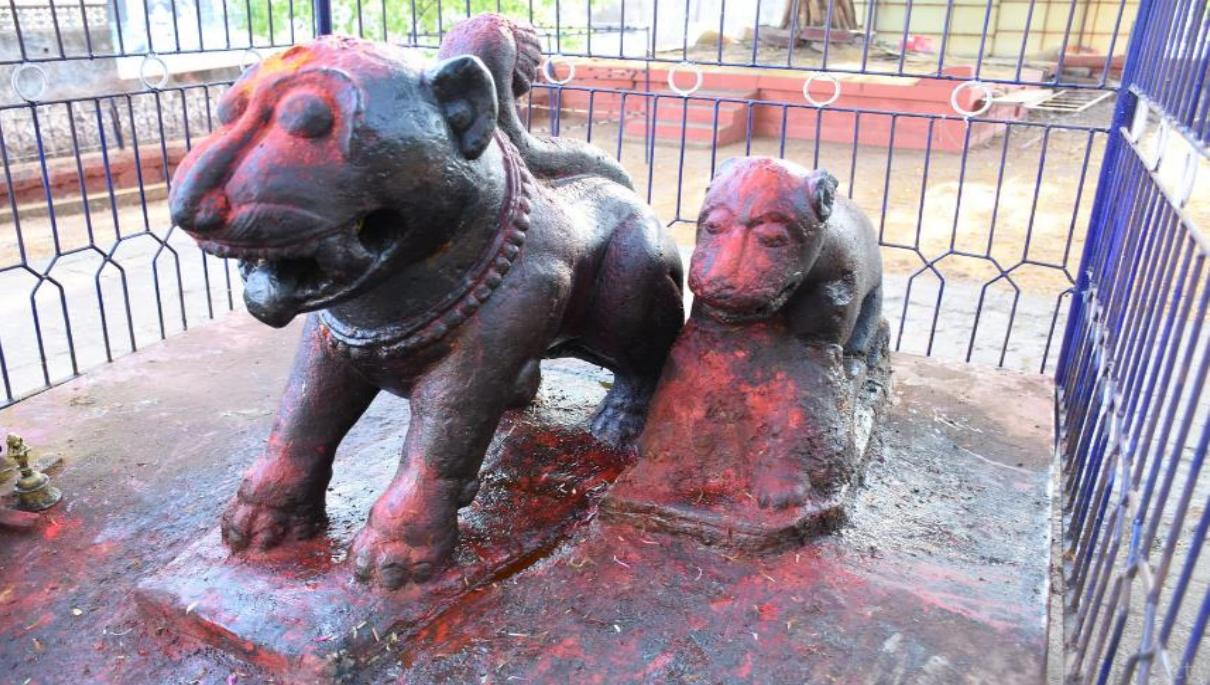

In [ ]:
#Displaying the top most relevant image from relevant images list

image_data = base64.b64decode(relevant_images[1])
display(Image(image_data))

#Conclusion

Checkout the [Github Link](https://github.com/chakka-guna-sekhar-venkata-chennaiah/Mutli-Modal-RAG-ChaBot) for Streamlit Deployment....

If you appreciate this project, kindly show your support by ⭐ starring the repository and voting for me on Quria. Your encouragement would mean a lot! Additionally, I'd be grateful if you could like 👍, share, and follow me on [LinkedIn](https://linkedin.com/in/chakka-guna-sekhar-venkata-chennaiah-7a6985208/) to stay connected and get updates on my latest work. Thank you! 🙏✨


